<a href="https://colab.research.google.com/github/Gialbo/COVID-Chest-X-Rays-Deep-Learning-analysis/blob/main/experiments/inceptionNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import libraries and data

In [ ]:
# IMPORT AND MOUNT DRIVE
import tensorflow as tf
import os
import os.path
import sys
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import tensorflow as tf
import keras
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# CLONE GITHUB REPOSITORY
!rm -r "COVID-Chest-X-Rays-Deep-Learning-analysis"
!git clone https://github.com/Gialbo/COVID-Chest-X-Rays-Deep-Learning-analysis.git

rm: cannot remove 'COVID-Chest-X-Rays-Deep-Learning-analysis': No such file or directory
Cloning into 'COVID-Chest-X-Rays-Deep-Learning-analysis'...
remote: Enumerating objects: 1095, done.
remote: Counting objects: 100% (506/506), done.
remote: Compressing objects: 100% (402/402), done.
remote: Total 1095 (delta 302), reused 256 (delta 104), pack-reused 589
Receiving objects: 100% (1095/1095), 109.79 MiB | 30.99 MiB/s, done.
Resolving deltas: 100% (565/565), done.


In [ ]:
# LOAD DIRECTORIES
sys.path.append('COVID-Chest-X-Rays-Deep-Learning-analysis/models')
sys.path.append('COVID-Chest-X-Rays-Deep-Learning-analysis/tools')

In [ ]:
# LOAD TRAINING DATA

from XRaysDataset import XRaysDataset

dataset = XRaysDataset(img_height=224, img_width=224, isInceptionNet=True)
train_ds, val_ds = dataset.load(train_val_split=True)

test_dir = '/content/drive/MyDrive/BIOINF/covid-project/dataset/test'
dataset = XRaysDataset(dir=test_dir, img_height=224,img_width=224, isInceptionNet=True)
test_ds, test_size = dataset.load(separate_classes=False)

Number of batches for the train dataset: 22
Number of batches for the validation dataset: 6
Dataset size  383
Number of batches for the dataset: 3


# Training

In [ ]:
from inceptionNet import inceptionNet
from plotter import plot_losses, plot_accuracies, plot_recalls, plot_precisions

In [ ]:
batch_size = 128
earlystopping = EarlyStopping(
    patience = 5
)

n_trials = 5
history = {}


for i in range(n_trials):
  history[str(i+1)] = []

  print("--------------- TRIAL " + str(i+1) + " --------------- ")

  checkpoint_path = os.path.join('/content/drive/MyDrive/BIOINF/checkpoints_classification/modelInc/standard', str(i+1) ,'weights.hdf5')

  checkpointer = ModelCheckpoint(
      filepath = checkpoint_path, 
      save_best_only = True
  )

  model = inceptionNet()
  history[str(i+1)] = model.fit(
      train_ds,
      validation_data = val_ds,
      batch_size = batch_size,
      epochs = 100, 
      callbacks = [earlystopping, checkpointer]
  )

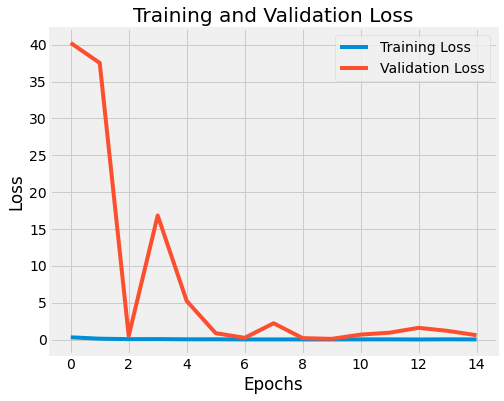

In [ ]:
plot_losses(history)

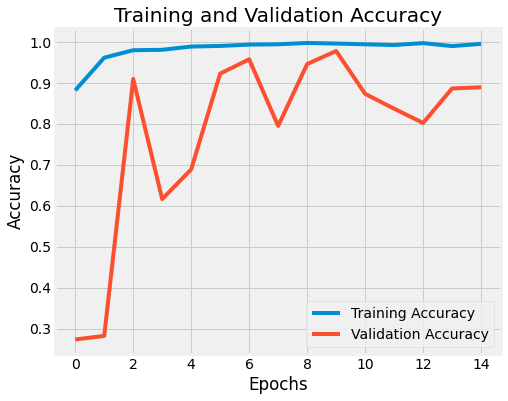

In [ ]:
plot_accuracies(history)

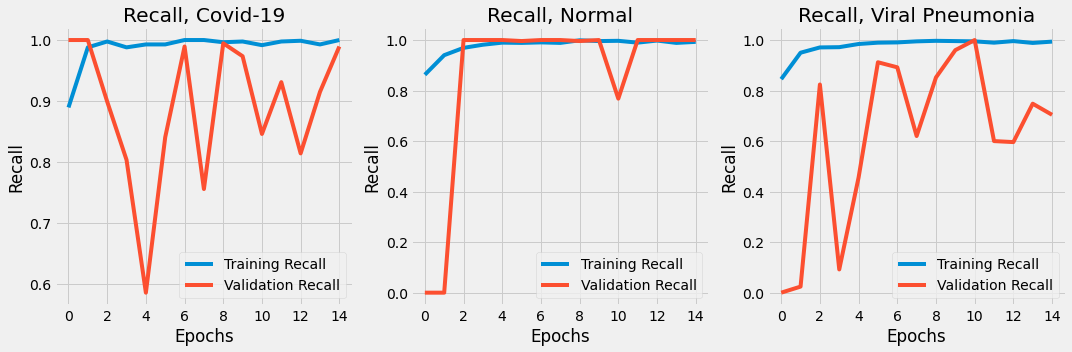

In [ ]:
plot_recalls(history)

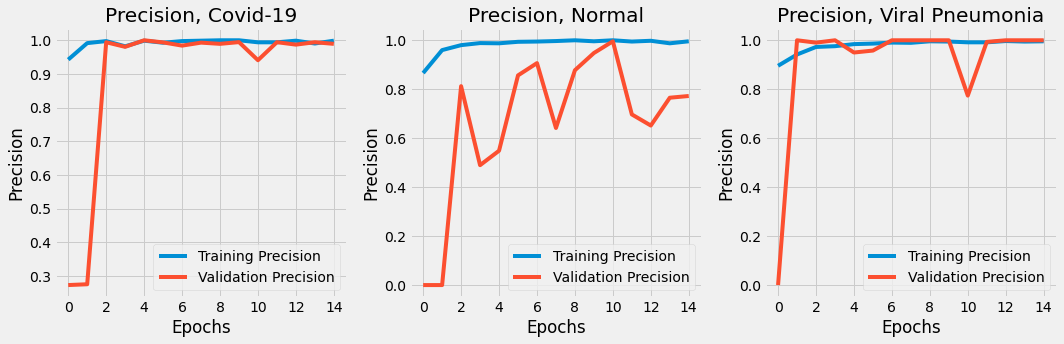

In [ ]:
plot_precisions(history)

# Training (without Early Stopping)

In [ ]:
batch_size = 128

history = {}

history['no_es'] = []

model = inceptionNet()
history['no_es'] = model.fit(
    train_ds,
    validation_data = val_ds,
    batch_size = batch_size,
    epochs = 50
)

Epoch 1/50
22/22 [==============================] - 20s 600ms/step - loss: 0.3336 - accuracy: 0.8592 - recall_3: 0.8874 - recall_4: 0.8363 - recall_5: 0.7859 - precision_3: 0.9590 - precision_4: 0.8855 - precision_5: 0.8686 - val_loss: 2.6798 - val_accuracy: 0.5741 - val_recall_3: 0.7395 - val_recall_4: 0.9916 - val_recall_5: 0.0000e+00 - val_precision_3: 0.6235 - val_precision_4: 0.5476 - val_precision_5: 0.0000e+00
Epoch 2/50
22/22 [==============================] - 11s 518ms/step - loss: 0.1022 - accuracy: 0.9688 - recall_3: 0.9816 - recall_4: 0.9588 - recall_5: 0.9607 - precision_3: 0.9877 - precision_4: 0.9608 - precision_5: 0.9677 - val_loss: 0.3981 - val_accuracy: 0.8561 - val_recall_3: 0.8233 - val_recall_4: 0.9076 - val_recall_5: 0.7915 - val_precision_3: 0.8985 - val_precision_4: 0.9191 - val_precision_5: 0.8194
Epoch 3/50
22/22 [==============================] - 11s 518ms/step - loss: 0.0715 - accuracy: 0.9782 - recall_3: 0.9804 - recall_4: 0.9825 - recall_5: 0.9669 - precis

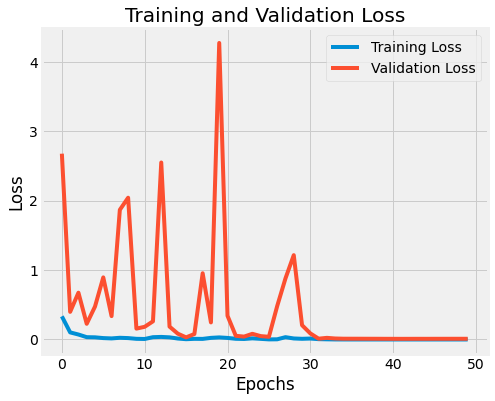

In [ ]:
train_loss = history['no_es'].history["loss"]
valid_loss = history['no_es'].history["val_loss"]

epochs = range(len(train_loss)) 
plt.figure(figsize=(8,6))
with plt.style.context('fivethirtyeight'):
  plt.plot(epochs, train_loss)
  plt.plot(epochs, valid_loss)
  plt.legend(["Training Loss", "Validation Loss"])
  plt.title("Training and Validation Loss")
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.show()

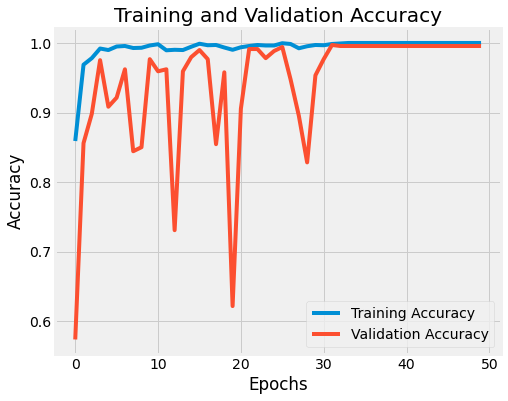

In [ ]:
train_acc = history['no_es'].history["accuracy"]
valid_acc = history['no_es'].history["val_accuracy"]

epochs = range(len(train_acc)) 
plt.figure(figsize=(8,6))

with plt.style.context('fivethirtyeight'):
  plt.plot(epochs, train_acc)
  plt.plot(epochs, valid_acc)
  plt.legend(["Training Accuracy", "Validation Accuracy"])
  plt.title("Training and Validation Accuracy")
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy")
  plt.show()

# Evaluate models

In [ ]:
results = {}

for i in range(n_trials):
  results[str(i+1)] = []

  print("--------------- TRIAL " + str(i+1) + " --------------- ")

  weights_path = os.path.join('/content/drive/MyDrive/BIOINF/checkpoints_classification/modelInc/standard', str(i+1) ,'weights.hdf5')
  model = inceptionNet()
  model.load_weights(weights_path)
  results[str(i+1)] = model.evaluate(test_ds, verbose=2)

--------------- TRIAL 1 --------------- 
3/3 - 6s - loss: 0.2703 - accuracy: 0.9530 - recall_15: 0.9565 - recall_16: 0.9478 - recall_17: 0.9552 - precision_15: 1.0000 - precision_16: 0.9478 - precision_17: 0.9209
--------------- TRIAL 2 --------------- 
3/3 - 4s - loss: 0.9604 - accuracy: 0.8956 - recall_18: 0.8087 - recall_19: 1.0000 - recall_20: 0.8657 - precision_18: 1.0000 - precision_19: 0.8171 - precision_20: 0.9206
--------------- TRIAL 3 --------------- 
3/3 - 4s - loss: 0.3727 - accuracy: 0.9452 - recall_21: 0.9652 - recall_22: 0.9925 - recall_23: 0.8806 - precision_21: 1.0000 - precision_22: 0.8808 - precision_23: 0.9752
--------------- TRIAL 4 --------------- 
3/3 - 4s - loss: 0.2308 - accuracy: 0.9687 - recall_24: 0.9826 - recall_25: 0.9403 - recall_26: 0.9851 - precision_24: 1.0000 - precision_25: 0.9844 - precision_26: 0.9296
--------------- TRIAL 5 --------------- 
3/3 - 4s - loss: 0.2639 - accuracy: 0.9608 - recall_27: 0.9826 - recall_28: 0.9478 - recall_29: 0.9552 - pr

In [ ]:
# compute meand and std for all the metrics
n_trials = 5
loss = np.zeros(n_trials)
accuracy = np.zeros(n_trials)
recall_covid = np.zeros(n_trials)
recall_normal = np.zeros(n_trials)
recall_viral_pneumonia = np.zeros(n_trials)
precision_covid = np.zeros(n_trials)
precision_normal = np.zeros(n_trials)
precision_viral_preumonia = np.zeros(n_trials)

for i in range(n_trials):
  loss[i] = results[str(i+1)][0]
  accuracy[i] = results[str(i+1)][1]
  recall_covid[i] = results[str(i+1)][2]
  recall_normal[i] = results[str(i+1)][3]
  recall_viral_pneumonia[i] = results[str(i+1)][4]
  precision_covid[i] = results[str(i+1)][5]
  precision_normal[i] = results[str(i+1)][6]
  precision_viral_preumonia[i] = results[str(i+1)][7]

print("--- LOSS ---")
print("Mean ", np.mean(loss))
print("Standard Deviation ", np.std(loss))
print("--- ACCURACY ---")
print("Mean ", np.mean(accuracy))
print("Standard Deviation ", np.std(accuracy))

print("--- RECALL, COVID 19 ---")
print("Mean ", np.mean(recall_covid))
print("Standard Deviation ", np.std(recall_covid))
print("--- RECALL, NORMAL ---")
print("Mean ", np.mean(recall_normal))
print("Standard Deviation ", np.std(recall_normal))
print("--- RECALL, VIRAL PNEUMONIA ---")
print("Mean ", np.mean(recall_viral_pneumonia))
print("Standard Deviation ", np.std(recall_viral_pneumonia))

print("--- PRECISION, COVID 19 ---")
print("Mean ", np.mean(precision_covid))
print("Standard Deviation ", np.std(precision_covid))
print("--- PRECISION, NORMAL ---")
print("Mean ", np.mean(precision_normal))
print("Standard Deviation ", np.std(precision_normal))
print("--- PRECISION, VIRAL PNEUMONIA ---")
print("Mean ", np.mean(precision_viral_preumonia))
print("Standard Deviation ", np.std(precision_viral_preumonia))

--- LOSS ---
Mean  0.4196054071187973
Standard Deviation  0.2745286724364997
--- ACCURACY ---
Mean  0.9446475148200989
Standard Deviation  0.02576271658663031
--- RECALL, COVID 19 ---
Mean  0.939130437374115
Standard Deviation  0.06599534821373804
--- RECALL, NORMAL ---
Mean  0.9656716346740722
Standard Deviation  0.02524110414445944
--- RECALL, VIRAL PNEUMONIA ---
Mean  0.9283581972122192
Standard Deviation  0.04662836010125814
--- PRECISION, COVID 19 ---
Mean  1.0
Standard Deviation  0.0
--- PRECISION, NORMAL ---
Mean  0.9169782519340515
Standard Deviation  0.0
--- PRECISION, VIRAL PNEUMONIA ---
Mean  0.9361177802085876
Standard Deviation  0.02023071969508277
